**1. Построение морфологического скелета** <br>
Разработать программу построения морфологического скелета изображения и восстановления изображения по морфологическому скелету для бинарных изображений и различных структурирующих элементов.

Содержание отчета: <br>
&emsp;Исходные изображения <br>
&emsp;Код программы (для Jupiter Notebook) <br>
&emsp;Результат работы программы <br>

In [1]:
# Import the necessary libraries
import cv2
import numpy as np
import matplotlib as mpl
import os
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation
%matplotlib inline

# Make global plot defaults
mpl.rcParams['image.cmap'] = 'copper'
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams["image.interpolation"] = None


C:\Users\kwx1191923\AppData\Local\Temp\ipykernel_360\3352488695.py:13: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams["image.interpolation"] = None


In [2]:
# Skeleton construction algorithm
# Return skeletal subset
def constructSkeleton(orig_img, kernel):
    img = orig_img.copy()
    skeleton = []

    opened_img = np.zeros(img.shape, np.uint8)
    while True:
        eroded_img = cv2.erode(img, kernel)
        if cv2.countNonZero(eroded_img) == 0:
            skeleton.append(img.copy())
            break

        # cv2.dilate work faster, but have troubles with non-symmetric kernel
        # opened_img = cv2.dilate(eroded_img, kernel, borderType=cv2.BORDER_REPLICATE)
        opened_img = binary_dilation(
            eroded_img, kernel).astype(eroded_img.dtype)
        skeleton.append(cv2.subtract(img, opened_img))
        img = eroded_img.copy()

    return skeleton


In [3]:
# Restore original image from skeleton
# Return restored image
def restoreFromSkeleton(skeleton, kernel):
    restored_img = np.zeros(skeleton[0].shape, np.uint8)
    n = len(skeleton)
    n -= 1

    while True:
        restored_img = cv2.bitwise_or(restored_img, skeleton[n])
        if n == 0:
            break

        # restored_img = cv2.dilate(restored_img, kernel)
        restored_img = binary_dilation(
            restored_img, kernel).astype(restored_img.dtype)
        n -= 1

    return restored_img


In [4]:
# Make skeleton for every image
# Restore image from skeleton
# Show results
def run(files, kernel):
    # Show kernel
    plt.figure(figsize=(1, 1))
    plt.title("Kernel", fontsize=10)
    plt.imshow(kernel, vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

    for file in files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img[img == 255] = 1

        skeleton = constructSkeleton(img, kernel)
        recovered_img = restoreFromSkeleton(skeleton, kernel)

        # Merge skeleton in one array
        merged_skeleton = np.zeros(img.shape, np.uint8)
        for skeleton_part in skeleton:
            merged_skeleton = cv2.bitwise_or(merged_skeleton, skeleton_part)

        # Check if correctness of recovery
        recovered_status = None
        if np.array_equal(img, recovered_img):
            recovered_status = "Recovered successfully"
        else:
            recovered_status = "Recovered with mistakes"

        # Show res
        out = plt.figure().subplot_mosaic(
            """
            ACC
            BCC
            """
        )

        out['A'].set_title("Original image")
        out['A'].axis("off")
        out['A'].imshow(img)

        out['B'].set_title(recovered_status)
        out['B'].axis("off")
        out['B'].imshow(recovered_img)

        out['C'].set_title("Its skelet")
        out['C'].axis("off")
        out['C'].imshow(merged_skeleton)

        plt.show()


**Starting point**

In [5]:
# Get image names
directory = "binary_images"
files = []

for filename in os.listdir(directory):
    files.append(os.path.join(directory, filename))


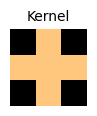

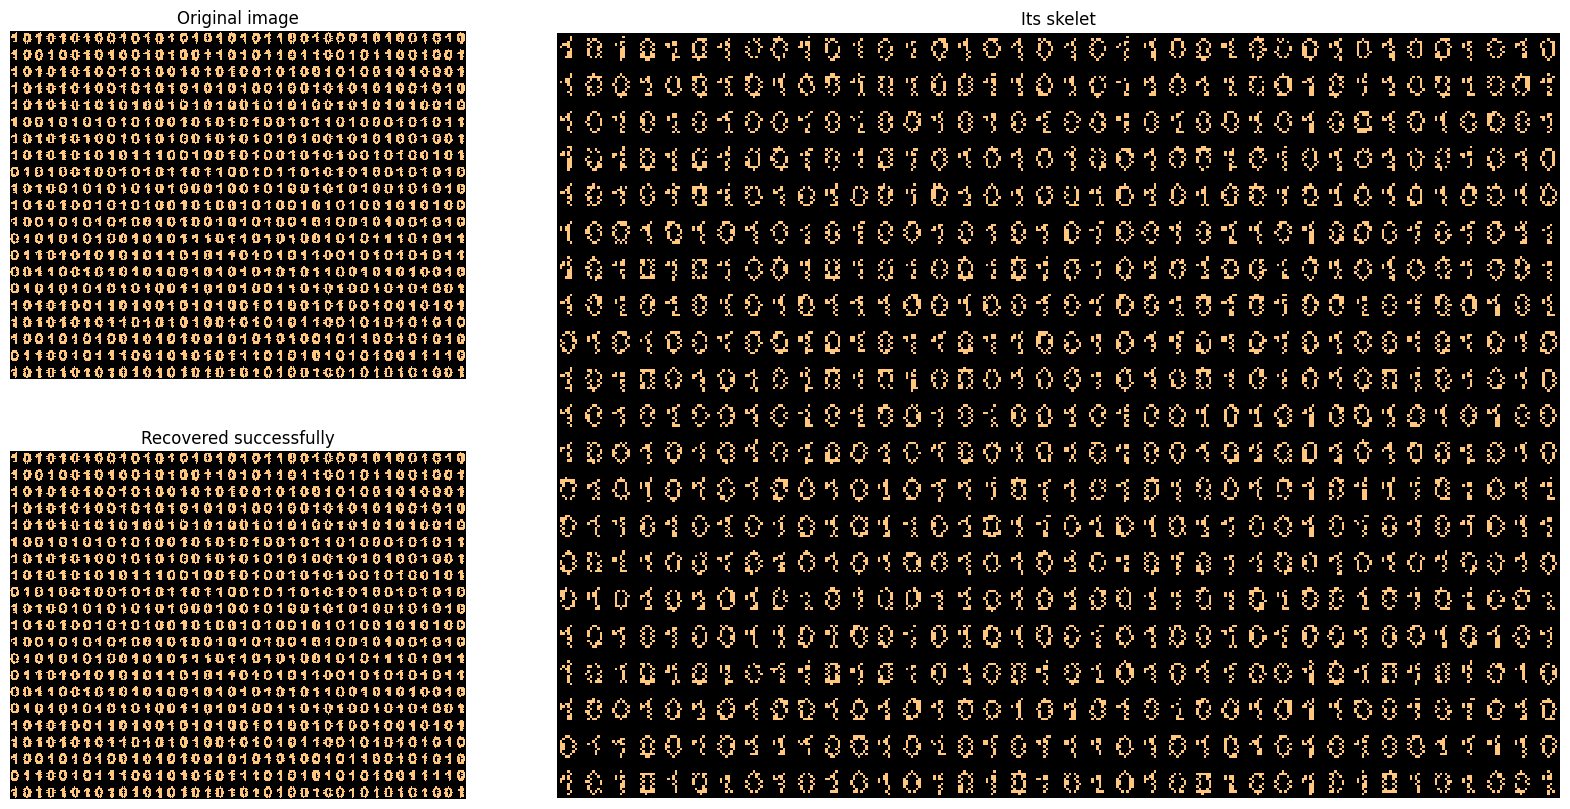

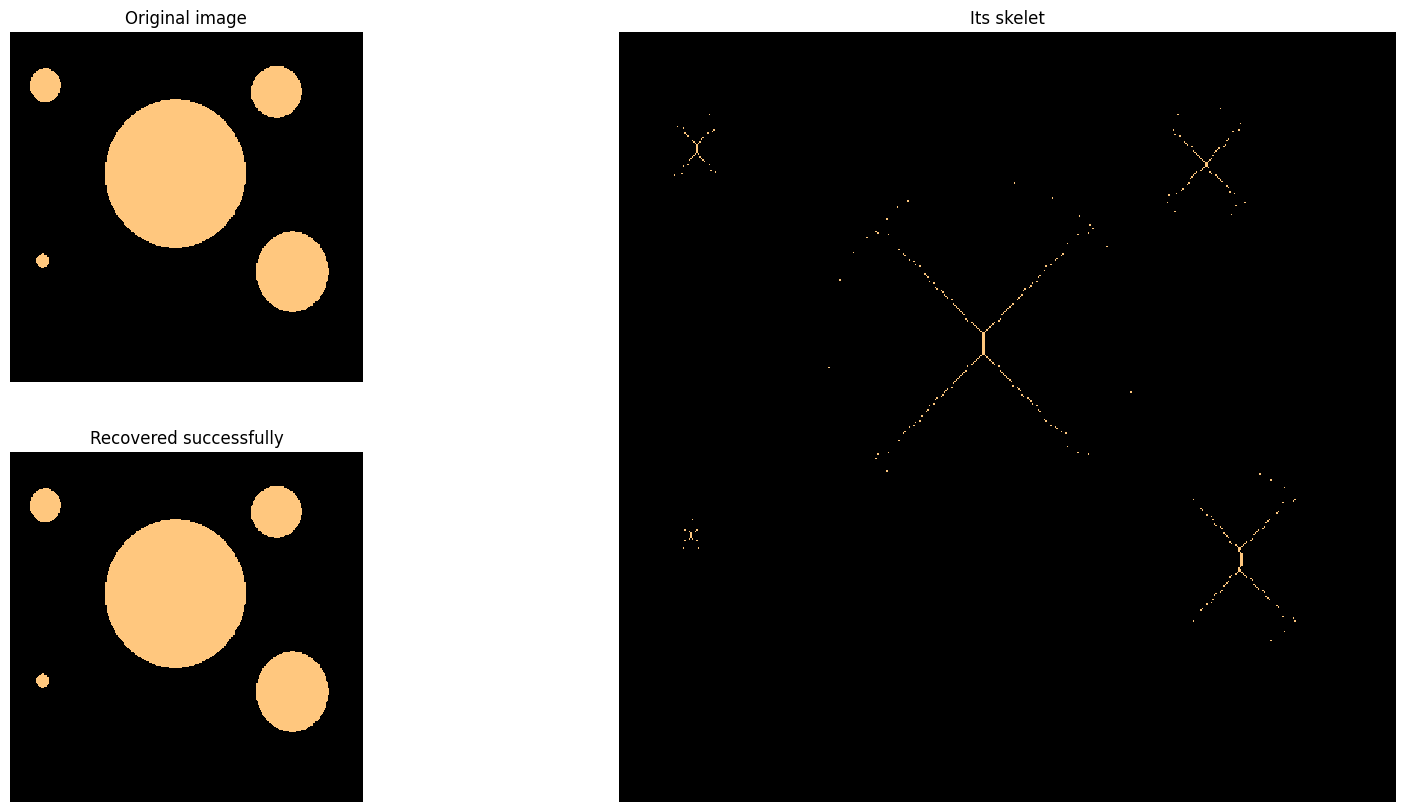

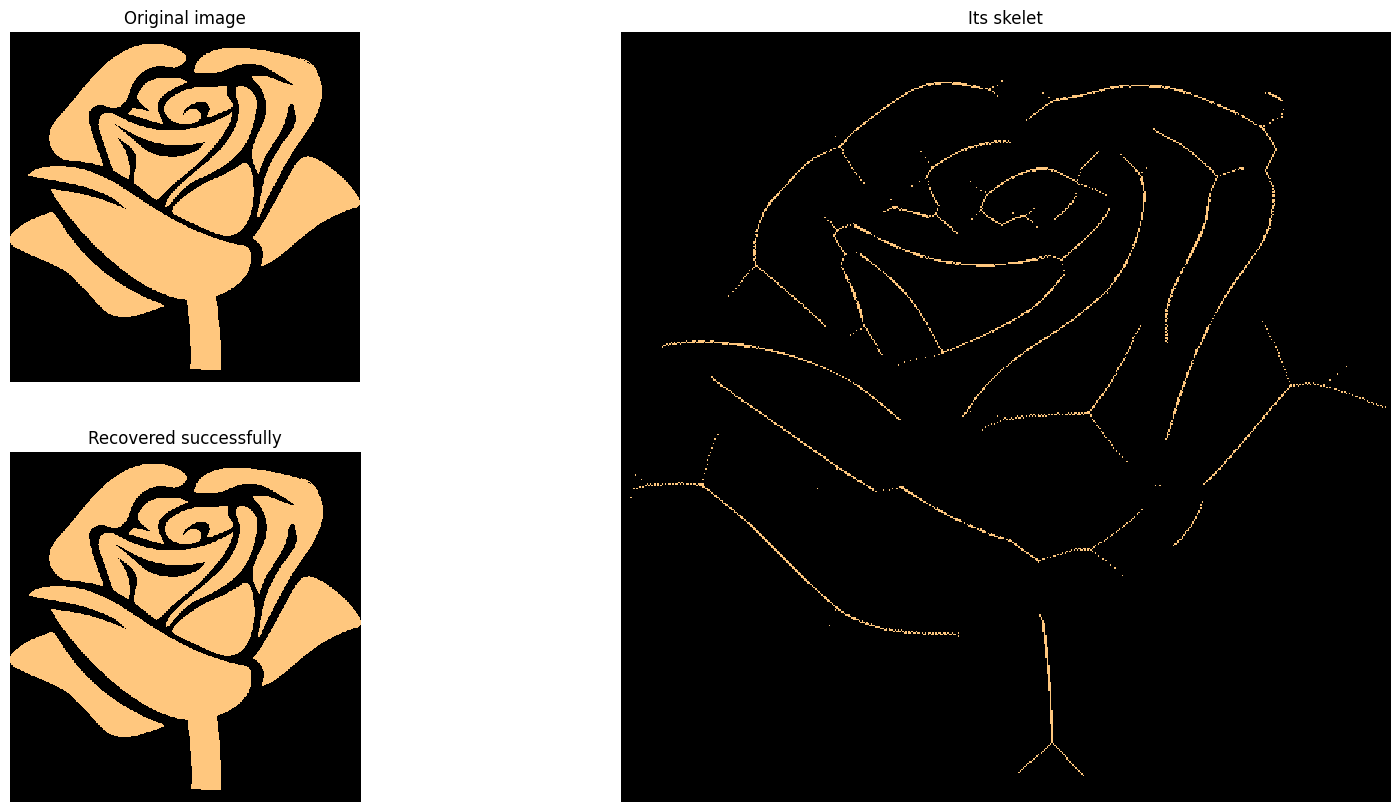

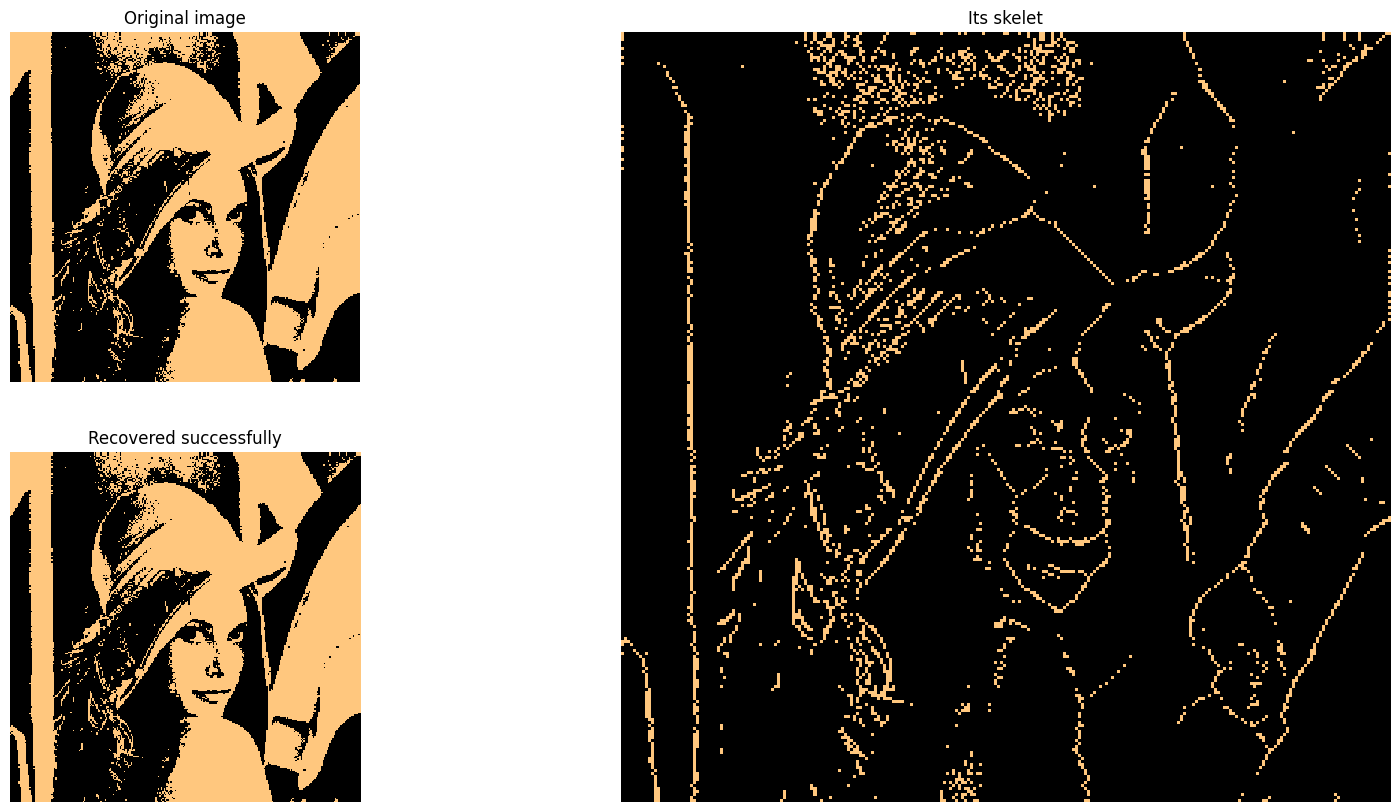

In [6]:
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

run(files, kernel_cross)


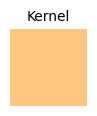

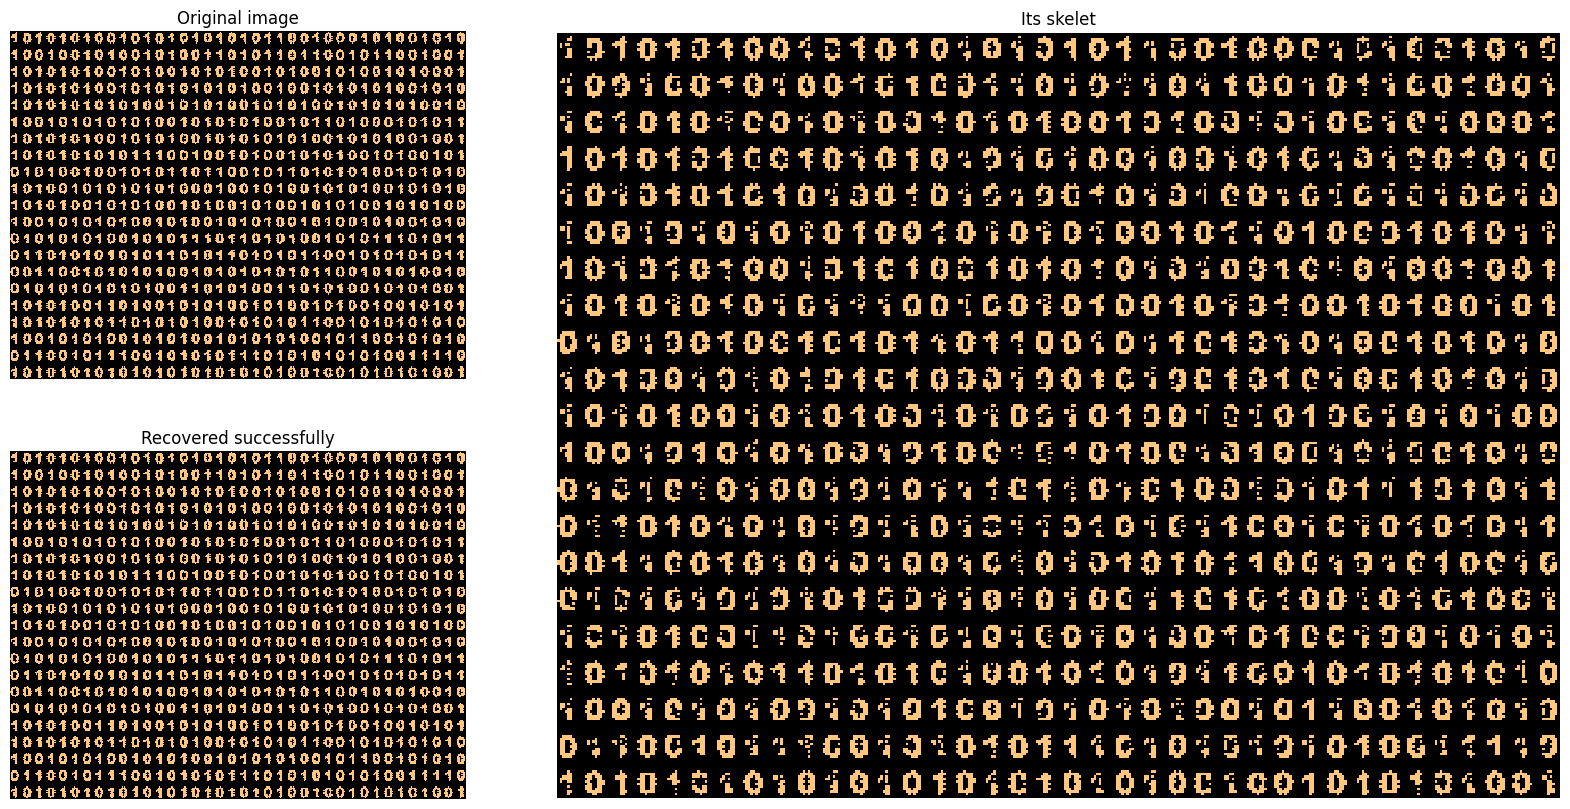

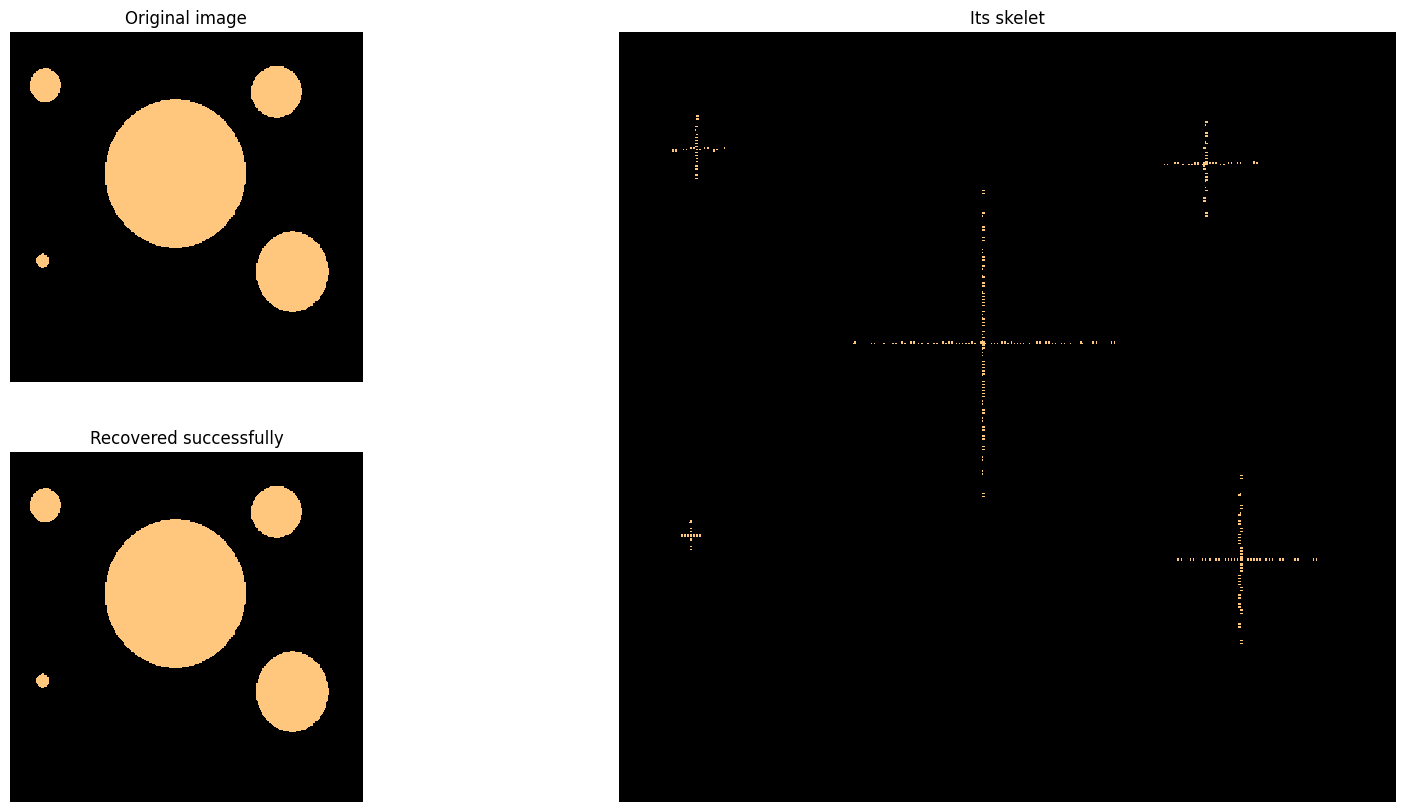

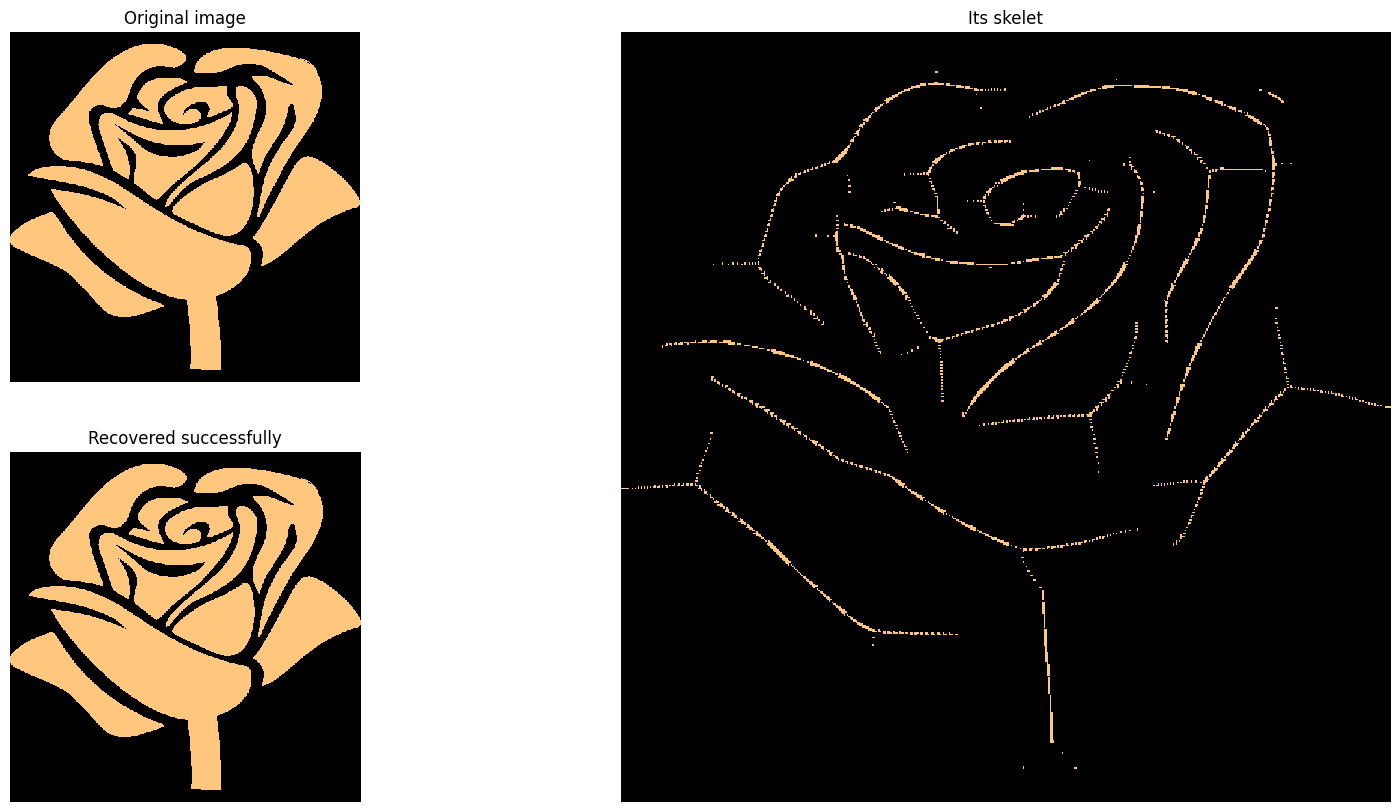

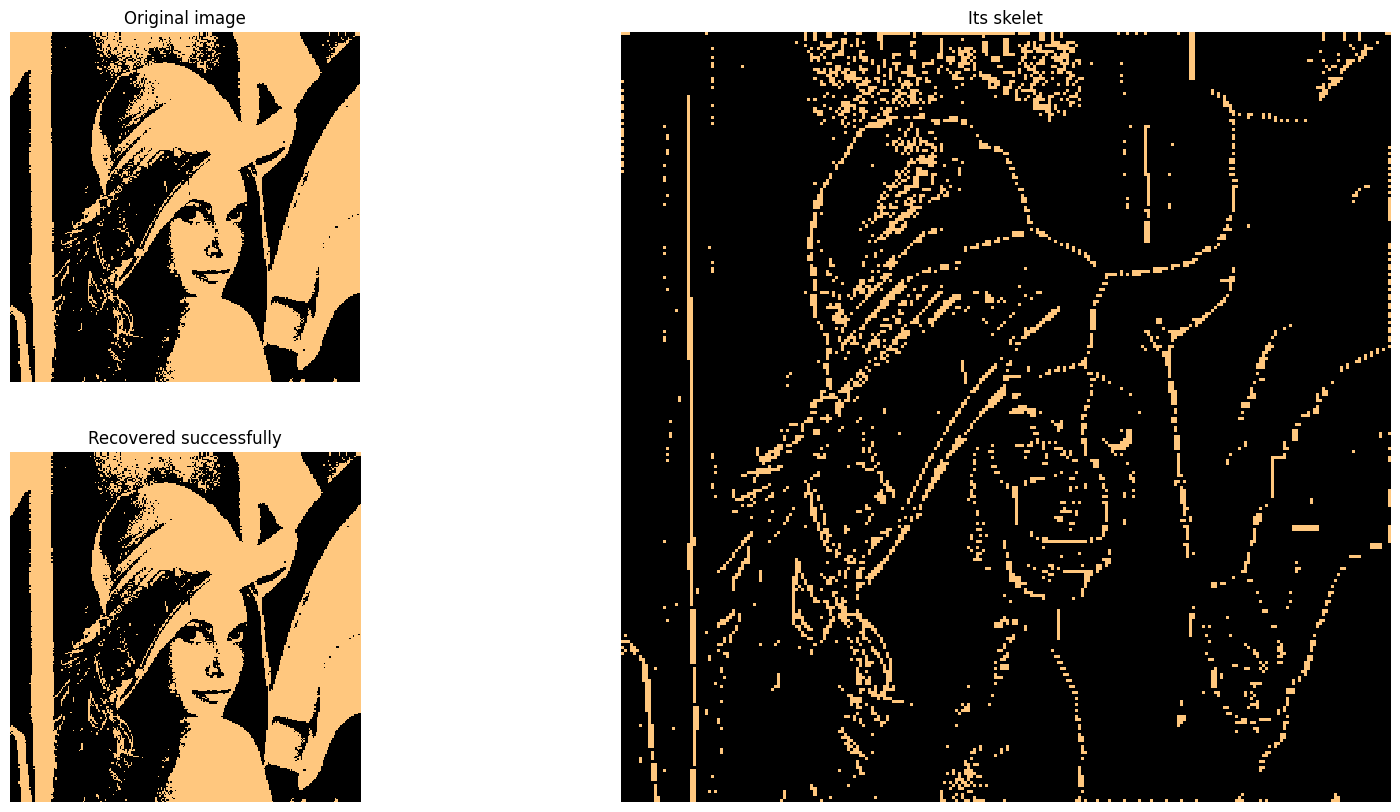

In [7]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

run(files, kernel_rect)


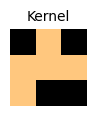

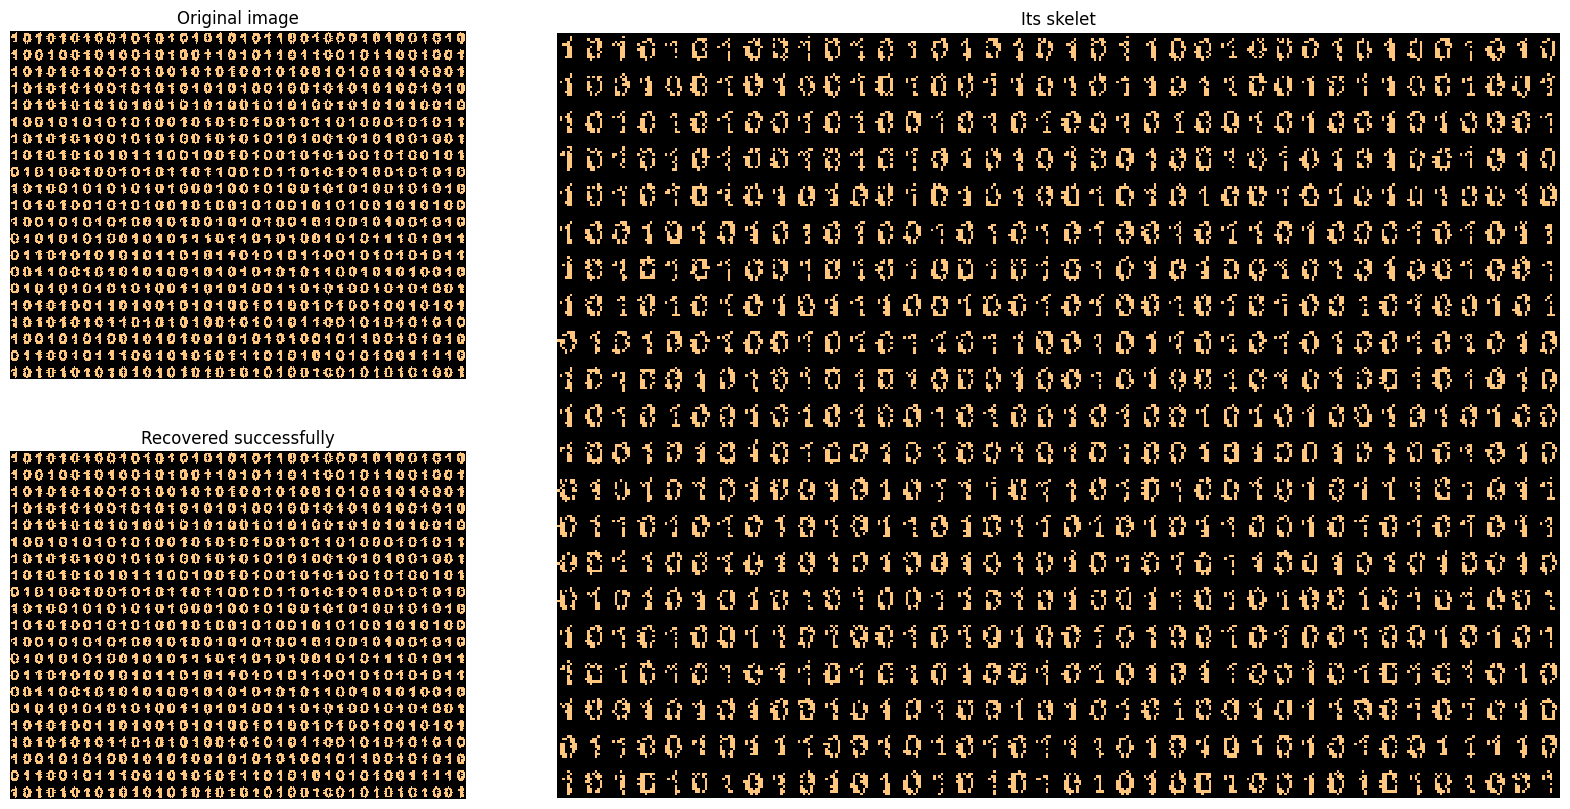

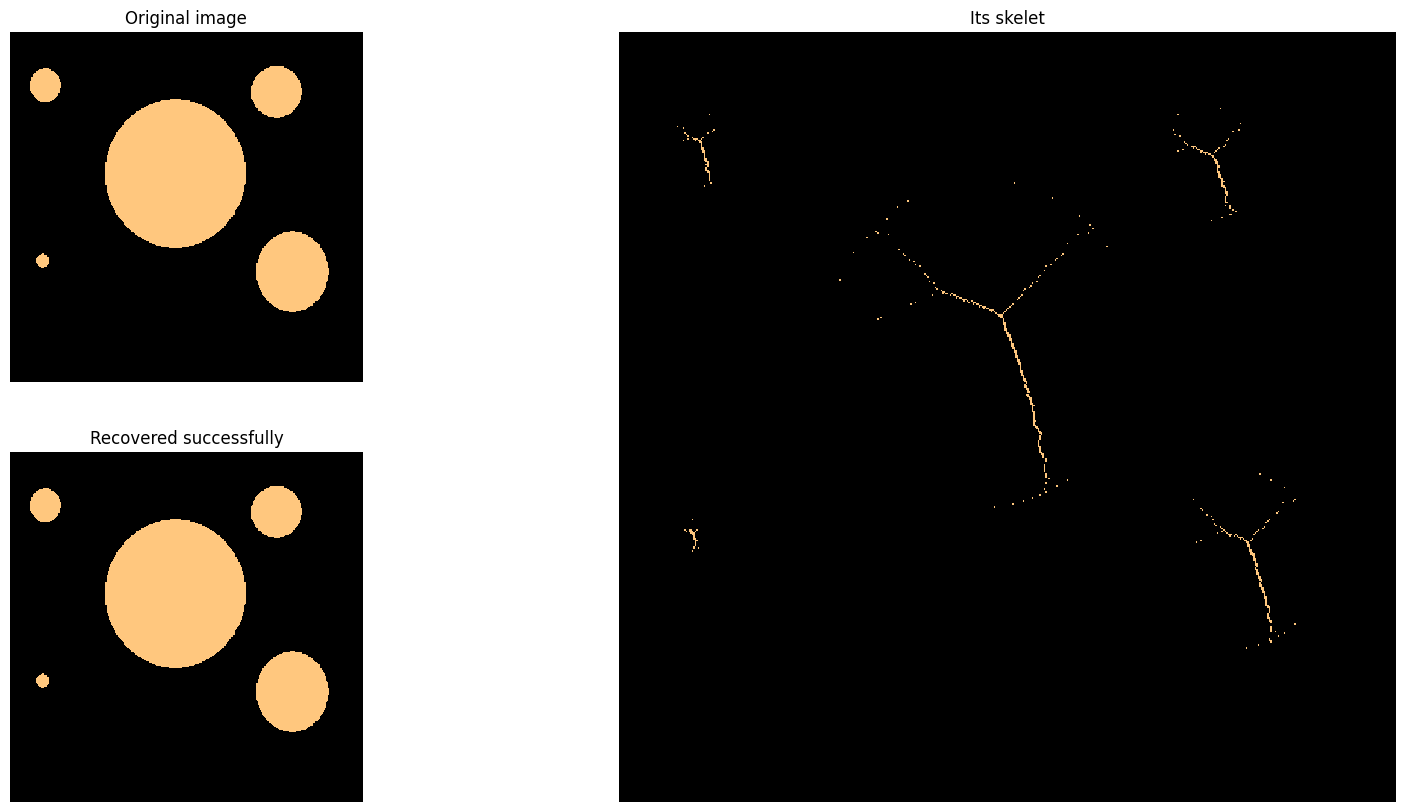

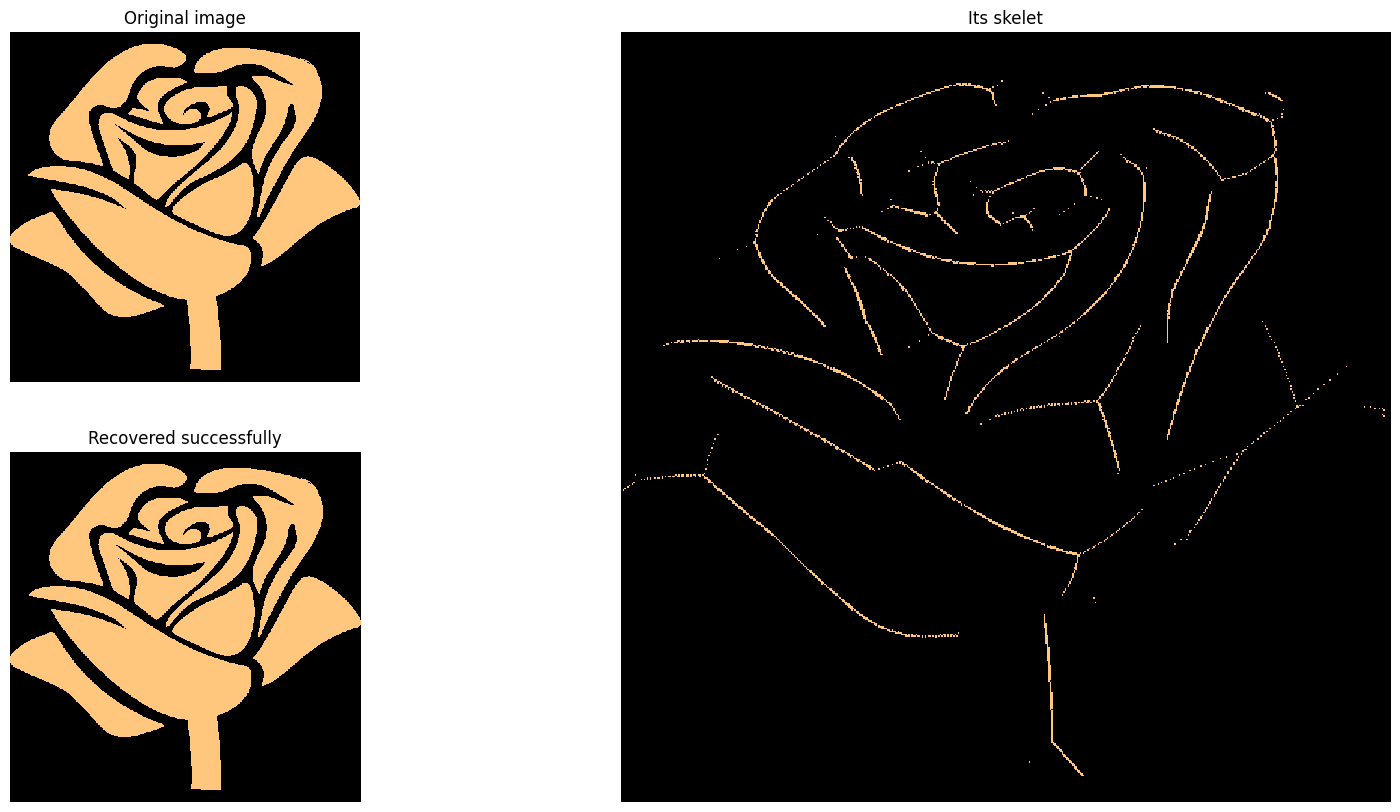

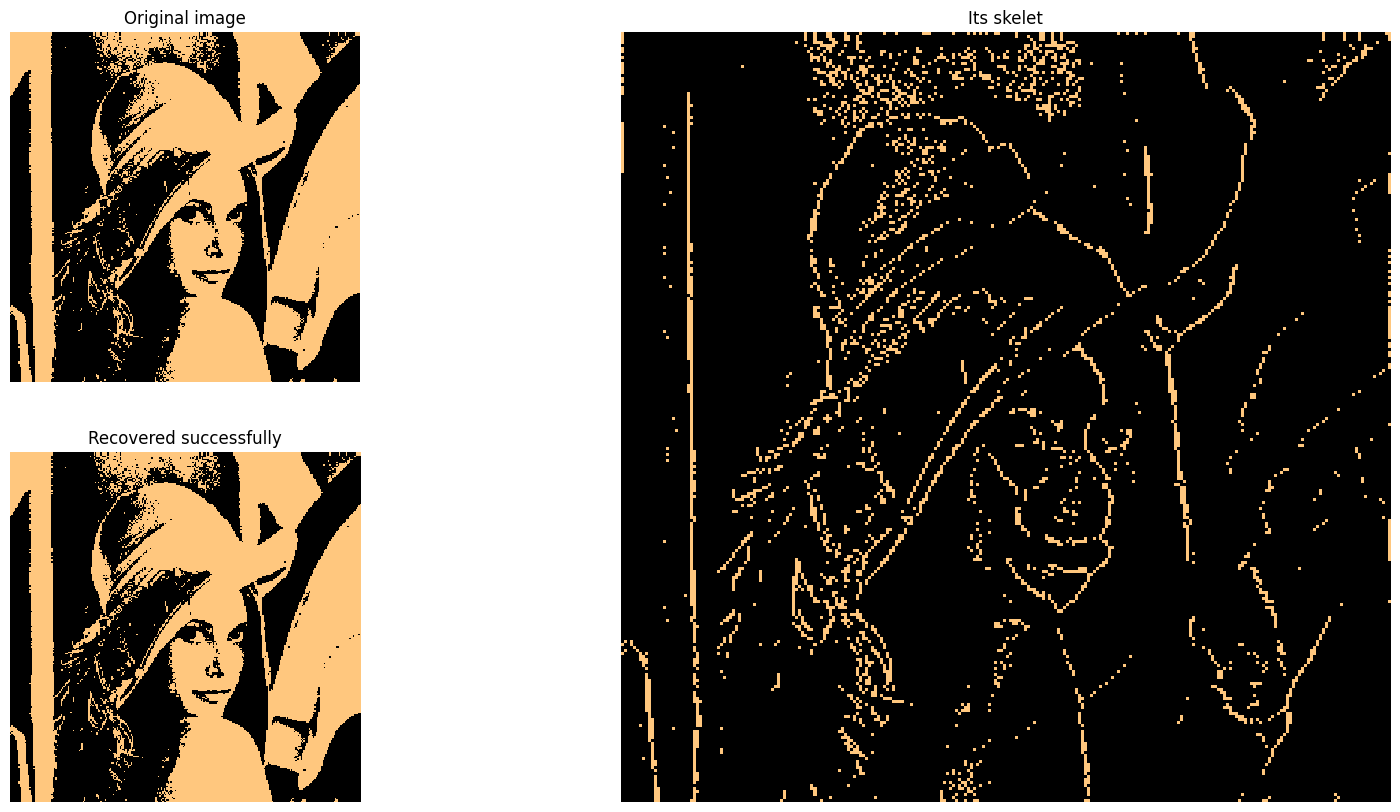

In [8]:
# Check non symmetric struct element
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
kernel[0, 0] = 0
kernel[0, 2] = 0
kernel[2, 1] = 0
kernel[2, 2] = 0

run(files, kernel)
